In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt


In [4]:
%pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [5]:
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

ones = np.ones(x1.shape)
X = torch.from_numpy(np.column_stack((ones,x1)))
X = X.to(torch.float32)
y = torch.from_numpy(y)
y = y.to(torch.float32)

In [6]:
X_T_X = torch.mm(X.T, X)
X_T_y = torch.mm(X.T, y.unsqueeze(1))
optTheta = torch.mm(torch.inverse(X_T_X), X_T_y)
optTheta = optTheta.view(-1)
optTheta

tensor([3.9507, 2.6825])

In [7]:
def true_gradient(X,y,theta):
    theta.requires_grad_(True)
    y_pred = torch.matmul(X,theta)
    loss = torch.mean((y_pred-y)**2)
    loss.backward()
    return theta.grad.detach().clone()

def stochastic_gradient(X,y,theta,num_samples):
    gradients = []
    theta.requires_grad_(True)
    theta.grad.zero_()
    for i in range(num_samples):
        y_pred = torch.matmul(X[i],theta)
        loss = (y_pred-y[i])**2
        loss.backward()
        gradients.append(theta.grad.clone())
        theta.grad.zero_()
    return sum(gradients)/num_samples

In [8]:
for trial in range(5):
    theta = torch.randint(0,10,(2,),dtype = torch.float32)
    True_gradient = true_gradient(X,y,theta)
    Stochastic_gradient = stochastic_gradient(X,y,theta,num_samples) 

    print(f'Trial {trial+1}')
    print(f"Theta Value:       {theta[0]:.4f}, {theta[1]:.4f}")
    print(f"True Gradient:       {True_gradient[0]:.4f}, {True_gradient[1]:.4f}")
    print(f"Stochastic Gradient: {Stochastic_gradient[0]:.4f}, {Stochastic_gradient[1]:.4f}")
    print()


Trial 1
Theta Value:       4.0000, 6.0000
True Gradient:       -0.4633, 2.0873
Stochastic Gradient: -0.4633, 2.0873

Trial 2
Theta Value:       7.0000, 7.0000
True Gradient:       5.3673, 2.2108
Stochastic Gradient: 5.3673, 2.2108

Trial 3
Theta Value:       1.0000, 2.0000
True Gradient:       -5.7858, 0.0687
Stochastic Gradient: -5.7858, 0.0687

Trial 4
Theta Value:       5.0000, 0.0000
True Gradient:       2.5529, -1.8722
Stochastic Gradient: 2.5529, -1.8722

Trial 5
Theta Value:       9.0000, 4.0000
True Gradient:       9.8754, -0.0230
Stochastic Gradient: 9.8754, -0.0230



In [9]:
def true_gradient_descent(X,y,theta,learning_rate,epsilon,max_epochs,optTheta):
    theta_evolution = []
    loss_tgd = []
    epoch_count = max_epochs
    for epoch in range(max_epochs):
        
        y_pred = torch.matmul(X,theta)
        loss = torch.mean((y_pred - y)**2)
        loss_tgd.append(loss.item())
        loss.backward()
        grad_norm = torch.norm(theta - optTheta)
        if grad_norm < epsilon:
            epoch_count = epoch+1
            break
        theta_evolution.append(theta.clone().detach())

        with torch.no_grad():
            theta -= theta.grad*learning_rate
            theta.grad.zero_()
        
    return theta_evolution,epoch_count,loss_tgd


import torch

def stochastic_gradient_descent(X, y, theta, learning_rate, epsilon, max_epochs, num_samples, optTheta):
    theta_evolution = []
    loss_sgd = []
    epoch_count = max_epochs
    iters_sgd = 0 
    theta.requires_grad_(True)
    
    for epoch in range(max_epochs):
        for i in range(num_samples):
            y_pred = torch.matmul(X[i], theta)
            loss = torch.mean((y_pred - y[i])**2)
            loss_sgd.append(loss.item())
            loss.backward()
            theta_evolution.append(theta.detach().clone())
            with torch.no_grad():
                theta -= learning_rate * theta.grad
                theta.grad.zero_()
            if torch.norm(theta - optTheta) < epsilon:
                epoch_count = epoch + 1
                iters_sgd = i
                break
        if torch.norm(theta - optTheta) < epsilon:
            break
    
    return theta_evolution, epoch_count, loss_sgd,iters_sgd


import torch

def mini_batch_gradient_descent(X, y, theta, learning_rate, epsilon, max_epochs, num_samples, batch_size, optTheta):
    theta_evolution = []
    loss_mbgd = []
    epoch_count = max_epochs
    num_batches = int(num_samples / batch_size)
    iters_mbgd = 0
    theta.requires_grad_(True)
    
    for epoch in range(max_epochs):
        for i in range(num_batches):
            batch_count = i+1
            X_batch = X[i * batch_size:(i + 1) * batch_size]
            y_batch = y[i * batch_size:(i + 1) * batch_size]
            y_pred = torch.matmul(X_batch, theta)
            loss = torch.mean((y_pred - y_batch) ** 2)
            loss_mbgd.append(loss.item())
            loss.backward()
            theta_evolution.append(theta.detach().clone())
            with torch.no_grad():
                theta -= learning_rate * theta.grad
                theta.grad.zero_()  
            if torch.norm(theta - optTheta) < epsilon:
                epoch_count = epoch + 1
                iters_mbgd = i
                break
        if torch.norm(theta - optTheta) < epsilon:
            break
    
    return theta_evolution,batch_count,epoch_count,loss_mbgd,iters_mbgd

def gradient_descent_with_momentum(X, y, theta, learning_rate, epsilon, max_epochs, beta,optTheta):
    theta_evolution_gdm = []
    loss_gdm = []
    epoch_count = max_epochs
    velocity = torch.zeros_like(theta)  
    
    for epoch in range(max_epochs):
        y_pred = torch.matmul(X, theta)
        loss = torch.mean((y_pred - y)**2)
        loss_gdm.append(loss.item())
        loss.backward()
        
        grad_norm = torch.norm(theta - optTheta)
        
        if grad_norm < epsilon:
            epoch_count = epoch + 1
            break
        
        theta_evolution_gdm.append(theta.clone().detach())
        
        with torch.no_grad():
            velocity = beta * velocity + (1 - beta) * theta.grad
            theta -= learning_rate * velocity  
            theta.grad.zero_()
    
    return theta_evolution_gdm, epoch_count, loss_gdm


In [21]:
def plot_gradient_descent(ax, X, y, theta_evolution, optTheta, title):
    theta0_vals = np.linspace(2, 5, 200)
    theta1_vals = np.linspace(1, 5.5, 200)
    T0, T1 = np.meshgrid(theta0_vals, theta1_vals)
    J_vals = np.zeros_like(T0)
    
    for i in range(len(theta0_vals)):
        for j in range(len(theta1_vals)):
            theta_ij = torch.tensor([T0[i, j], T1[i, j]], dtype=torch.float32)
            y_pred = torch.matmul(X, theta_ij)
            J_vals[i, j] = torch.mean((y_pred - y)**2).item()
    
    heatmap = ax.imshow(J_vals, extent=[theta0_vals.min(), theta0_vals.max(), theta1_vals.min(), theta1_vals.max()],
                        origin='lower', aspect='auto', cmap='jet', alpha=0.75)
    
    ax.contour(T0, T1, J_vals, levels=np.logspace(-2, 3, 20), cmap='viridis', alpha=0.7)
    
    theta_evolution = np.array(theta_evolution[:50])
    ax.plot(theta_evolution[:, 0], theta_evolution[:, 1], 'ro-', label='Convergence Path')
    
    ax.plot(theta_evolution[0, 0], theta_evolution[0, 1], 'go', label='Initial Theta')
    ax.plot(optTheta[0].item(), optTheta[1].item(), 'kx', markersize=10, label='Optimal Theta')
    
    ax.set_xlabel(r'$\theta_0$', fontsize=10)
    ax.set_ylabel(r'$\theta_1$', fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.legend(fontsize=8)
    ax.grid(True)

def lossvepoch(ax, loss, method_name):
    filtered_loss = [l for l in loss if l >= 0.005]
    ax.plot(range(len(filtered_loss)), filtered_loss, color='blue', linestyle='-', marker='o', markersize=4, label=f'{method_name} Loss')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.set_title(f'Loss vs Epochs ({method_name})', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=8)

def plot_all(X, y, theta_evolution_tgd, theta_evolution_sgd, theta_evolution_mbgd, theta_evolution_gdm,
             loss_tgd, loss_sgd, loss_mbgd, loss_gdm, optTheta):
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))

    plot_gradient_descent(axes[0, 0], X, y, theta_evolution_tgd, optTheta, 'True Gradient Descent')
    plot_gradient_descent(axes[0, 1], X, y, theta_evolution_sgd, optTheta, 'Stochastic Gradient Descent')
    plot_gradient_descent(axes[0, 2], X, y, theta_evolution_mbgd, optTheta, 'Mini-batch Gradient Descent')
    plot_gradient_descent(axes[0, 3], X, y, theta_evolution_gdm, optTheta, 'Gradient Descent with Momentum')

    lossvepoch(axes[1, 0], loss_tgd, 'True Gradient Descent')
    lossvepoch(axes[1, 1], [loss_sgd[40*i] for i in range(int(len(loss_sgd)/40))], 'Stochastic Gradient Descent')
    lossvepoch(axes[1, 2], [loss_mbgd[8*i] for i in range(int(len(loss_mbgd)/8))], 'Mini-batch Gradient Descent')
    lossvepoch(axes[1, 3], loss_gdm, 'Gradient Descent with Momentum')

    plt.tight_layout()
    plt.show()


In [22]:
max_epochs = 300
learning_rate = 0.05
epsilon = 0.001
batch_size = 5
beta = 0.9




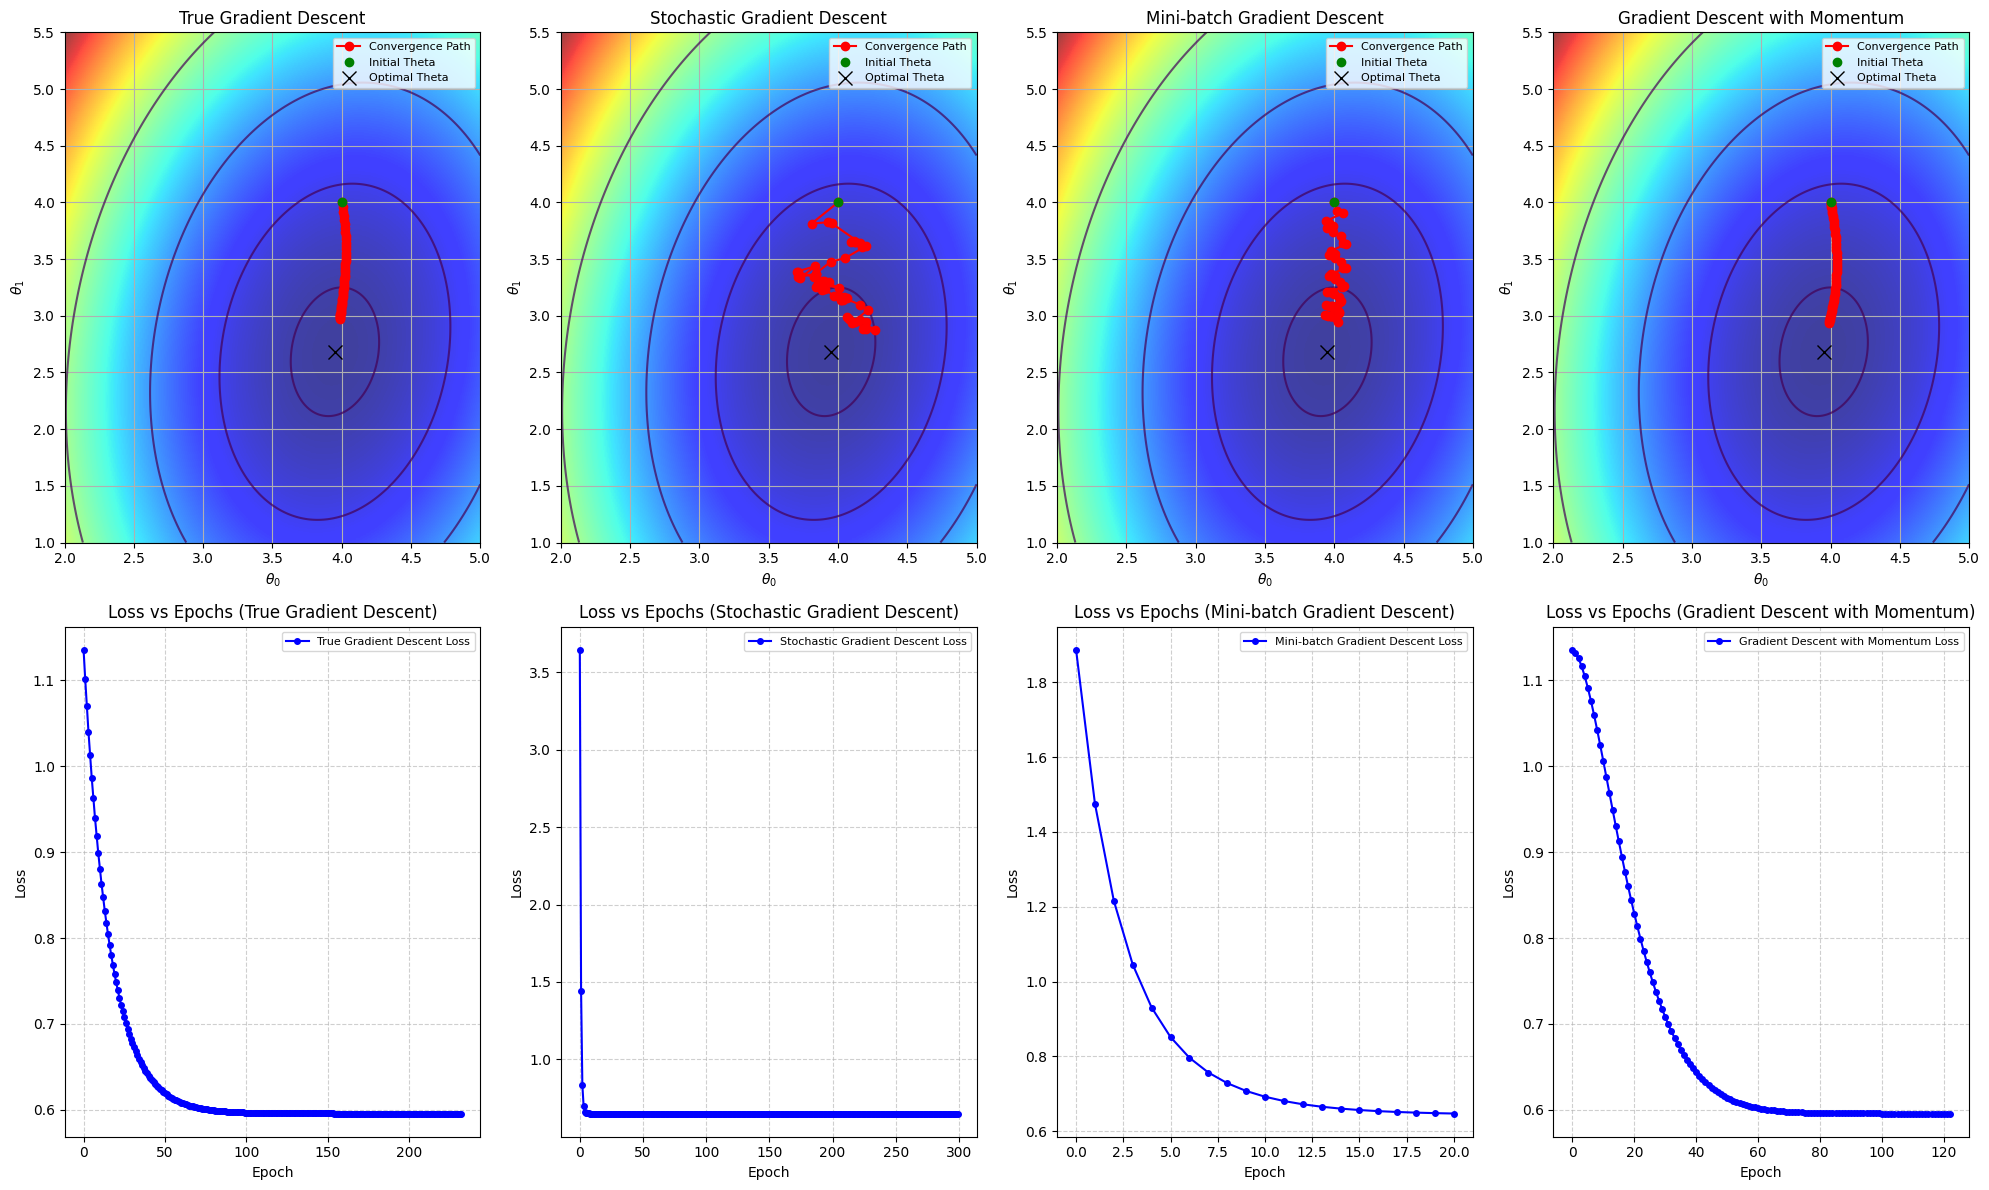

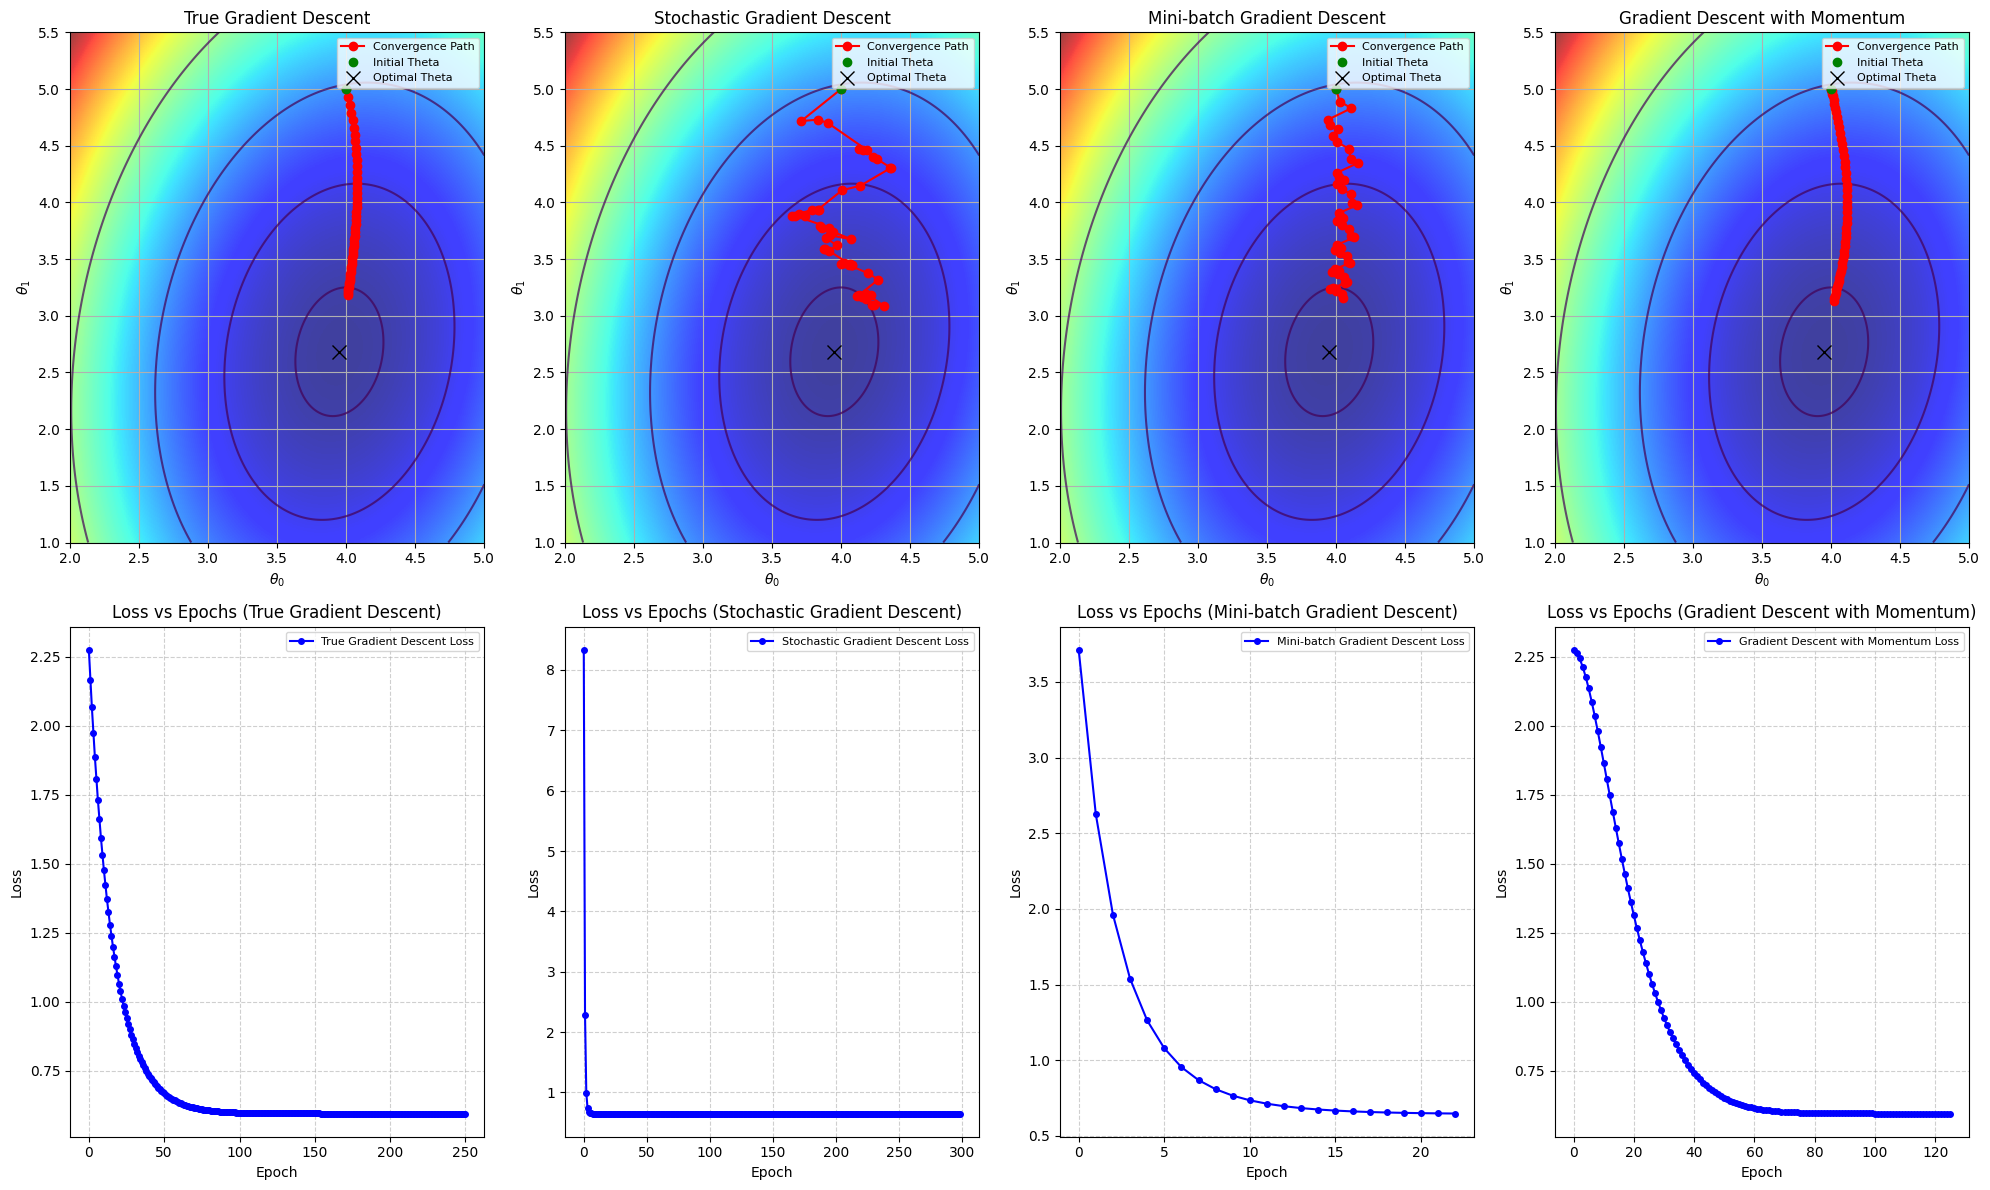

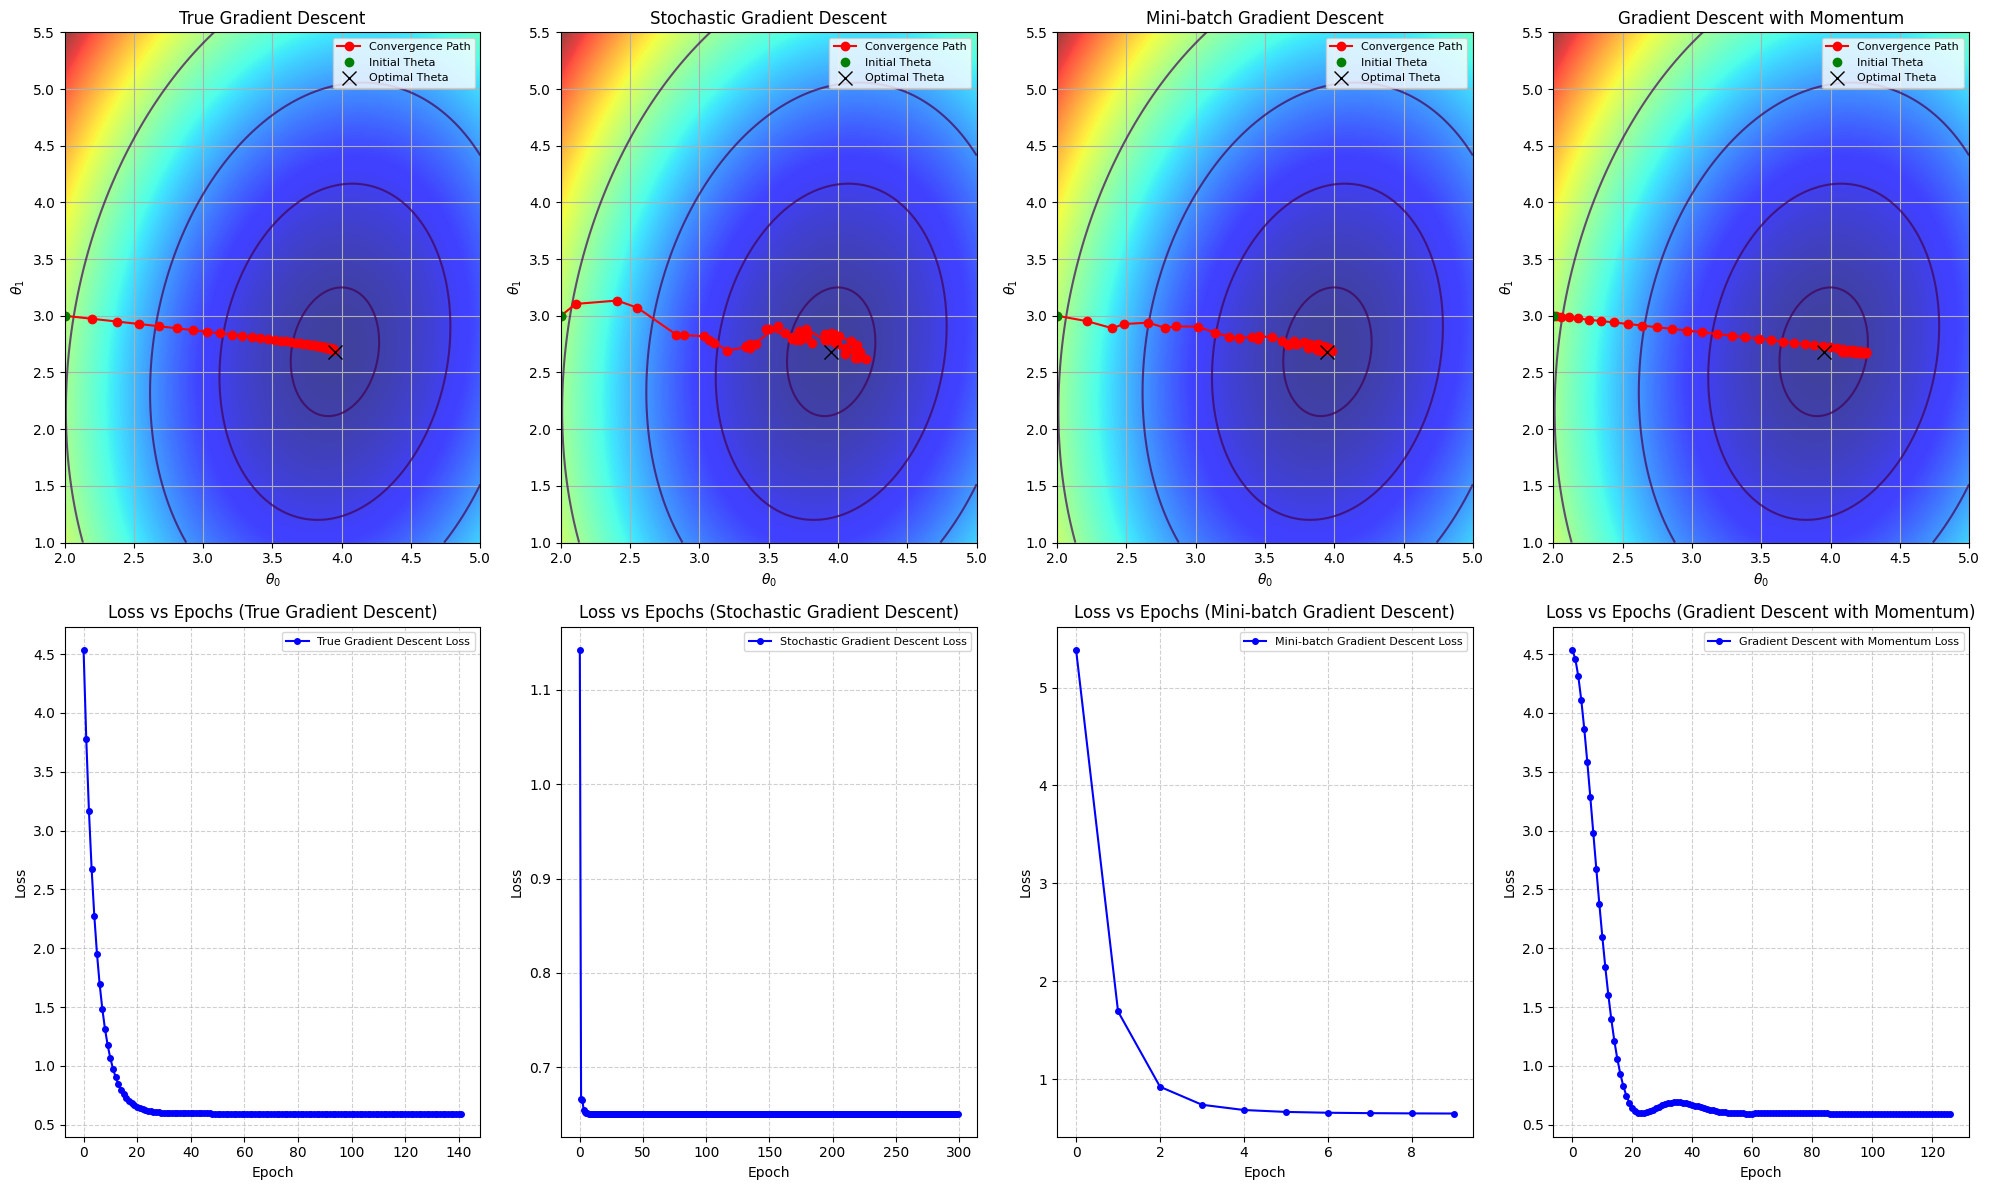

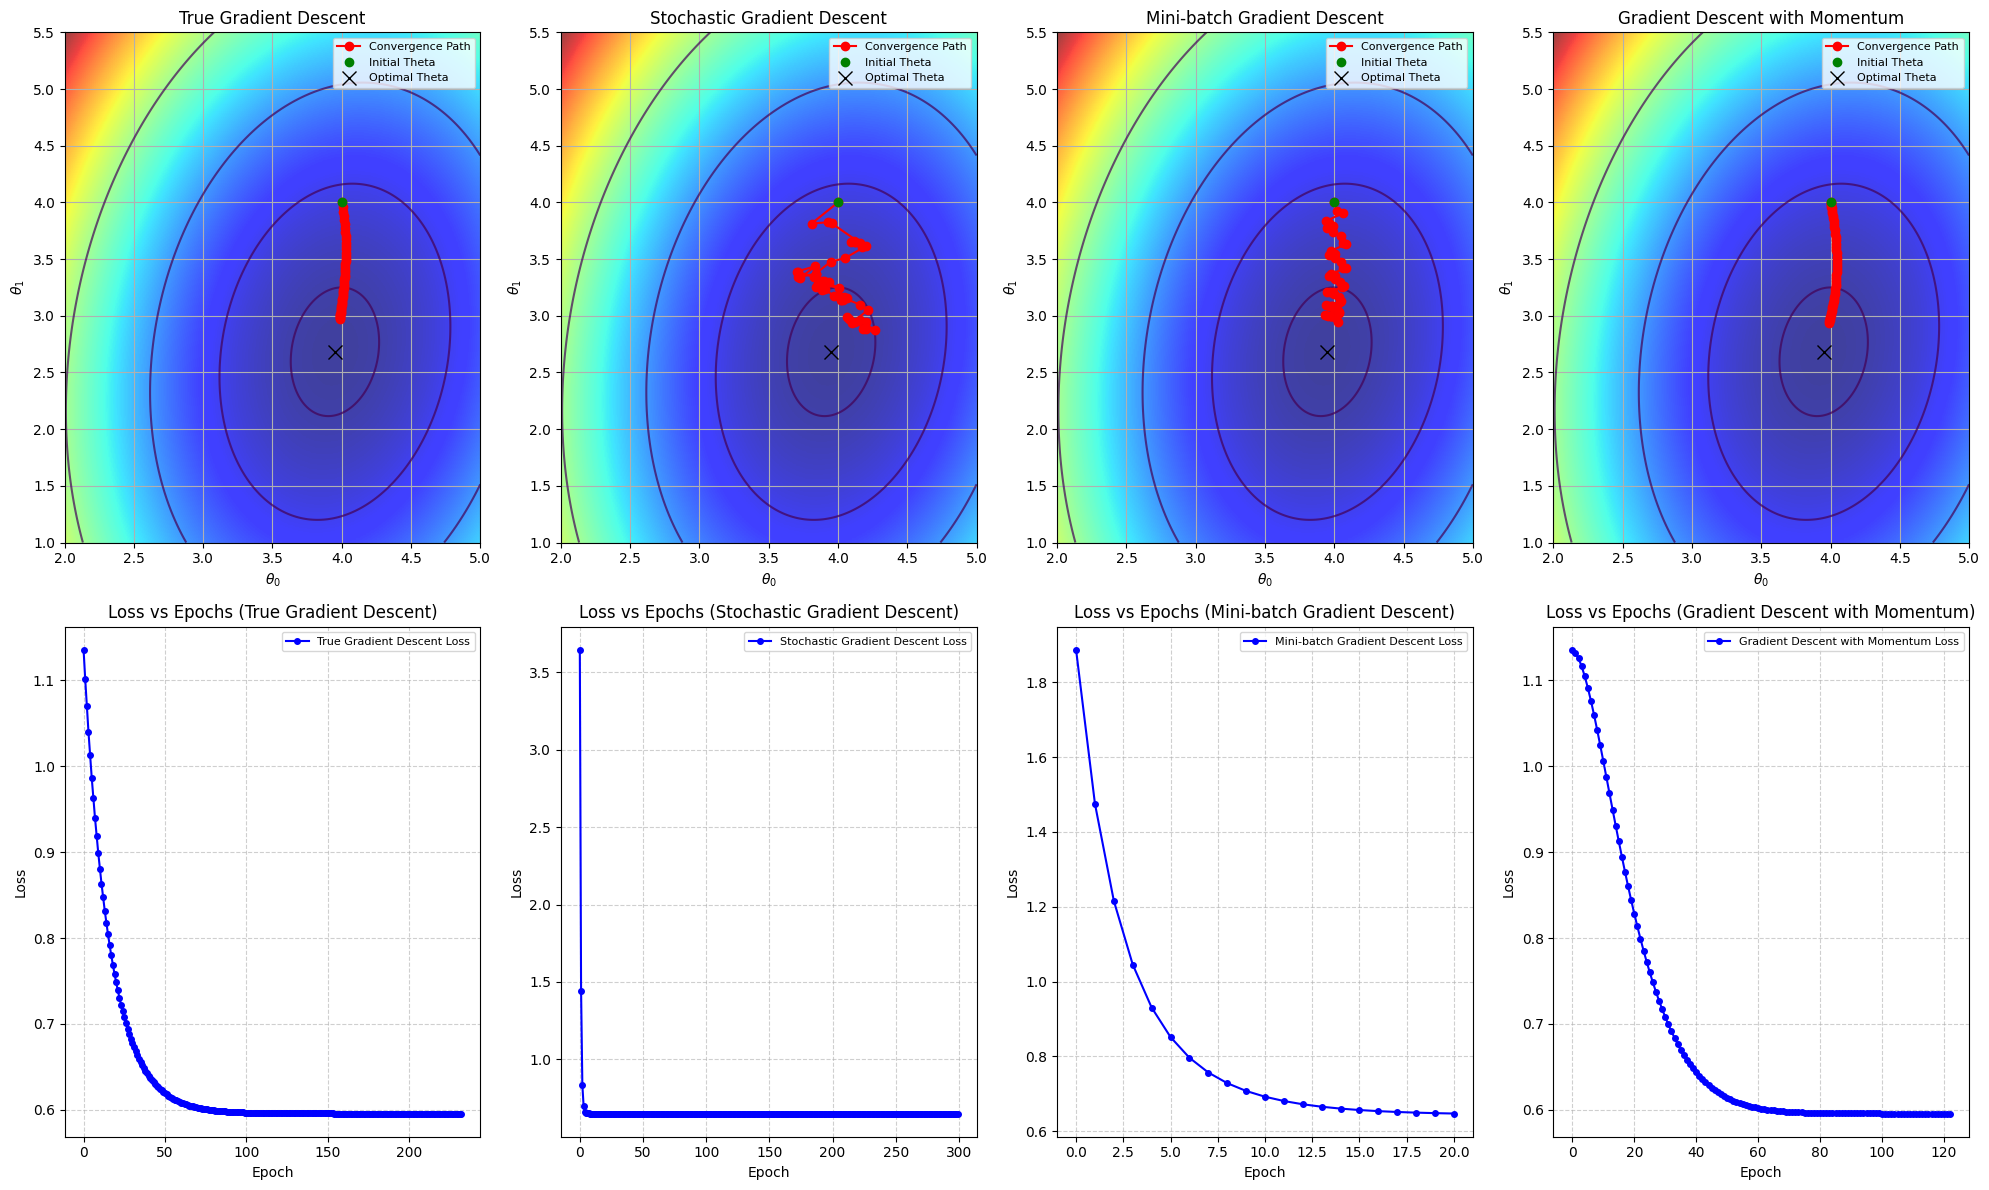

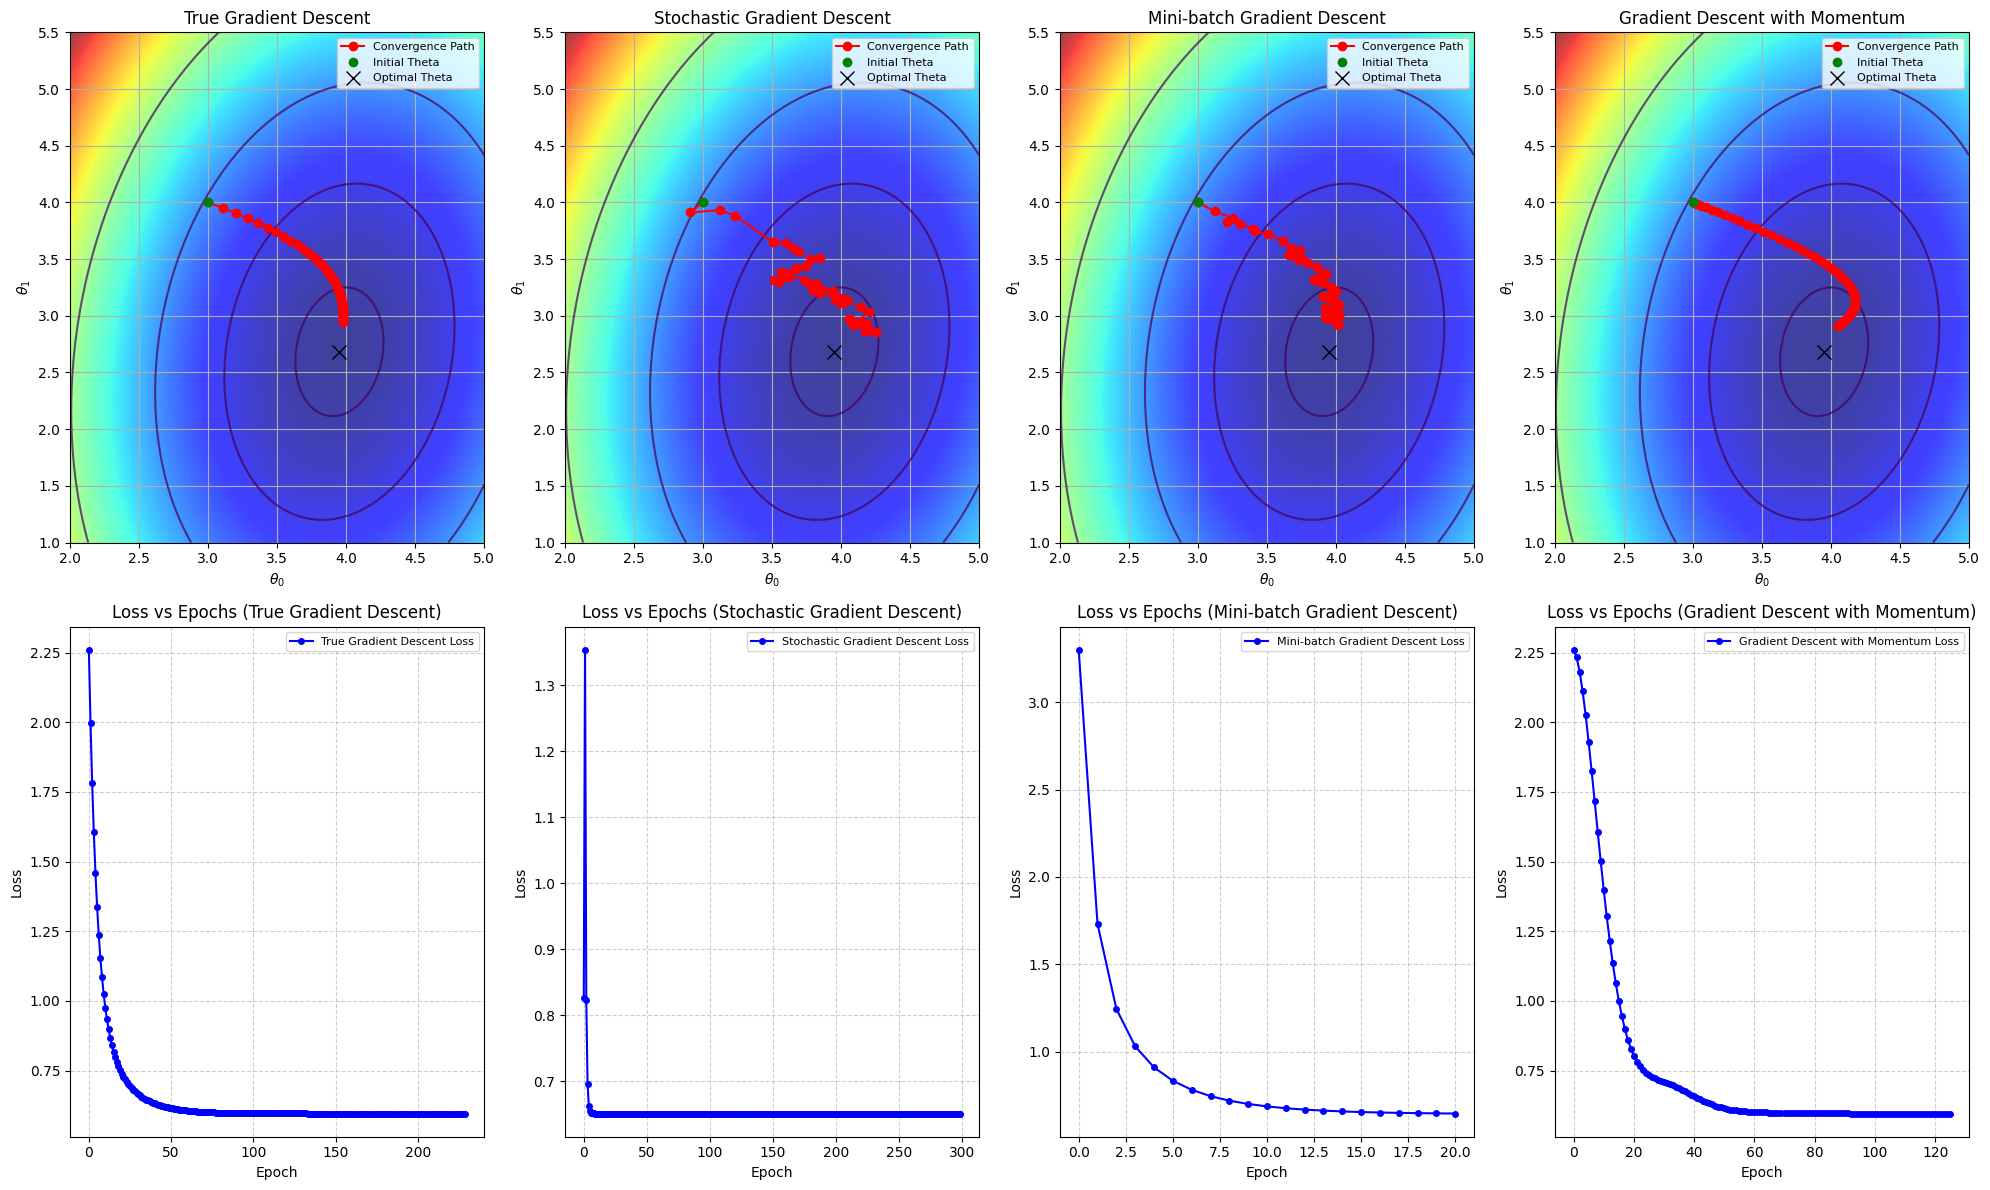

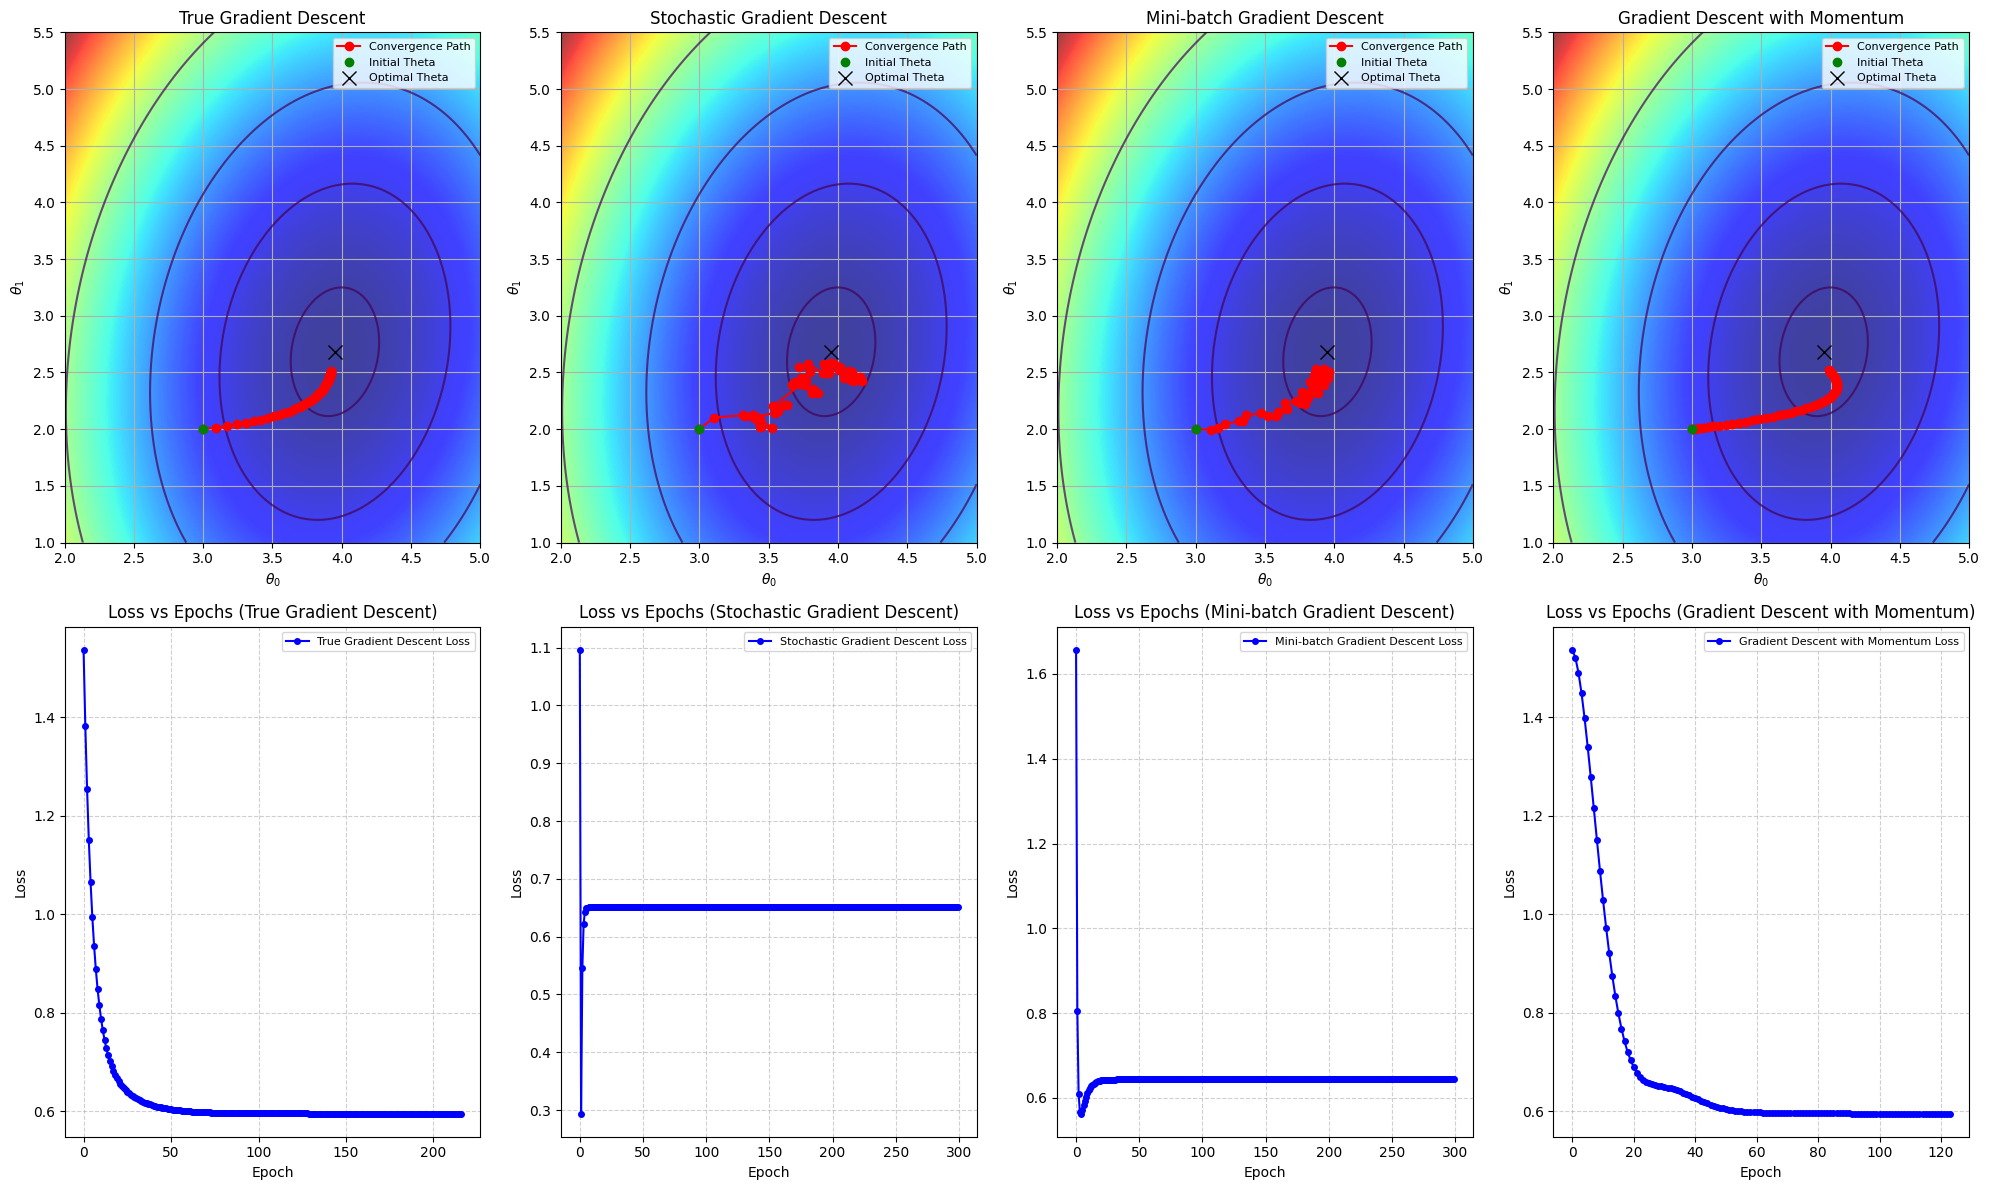

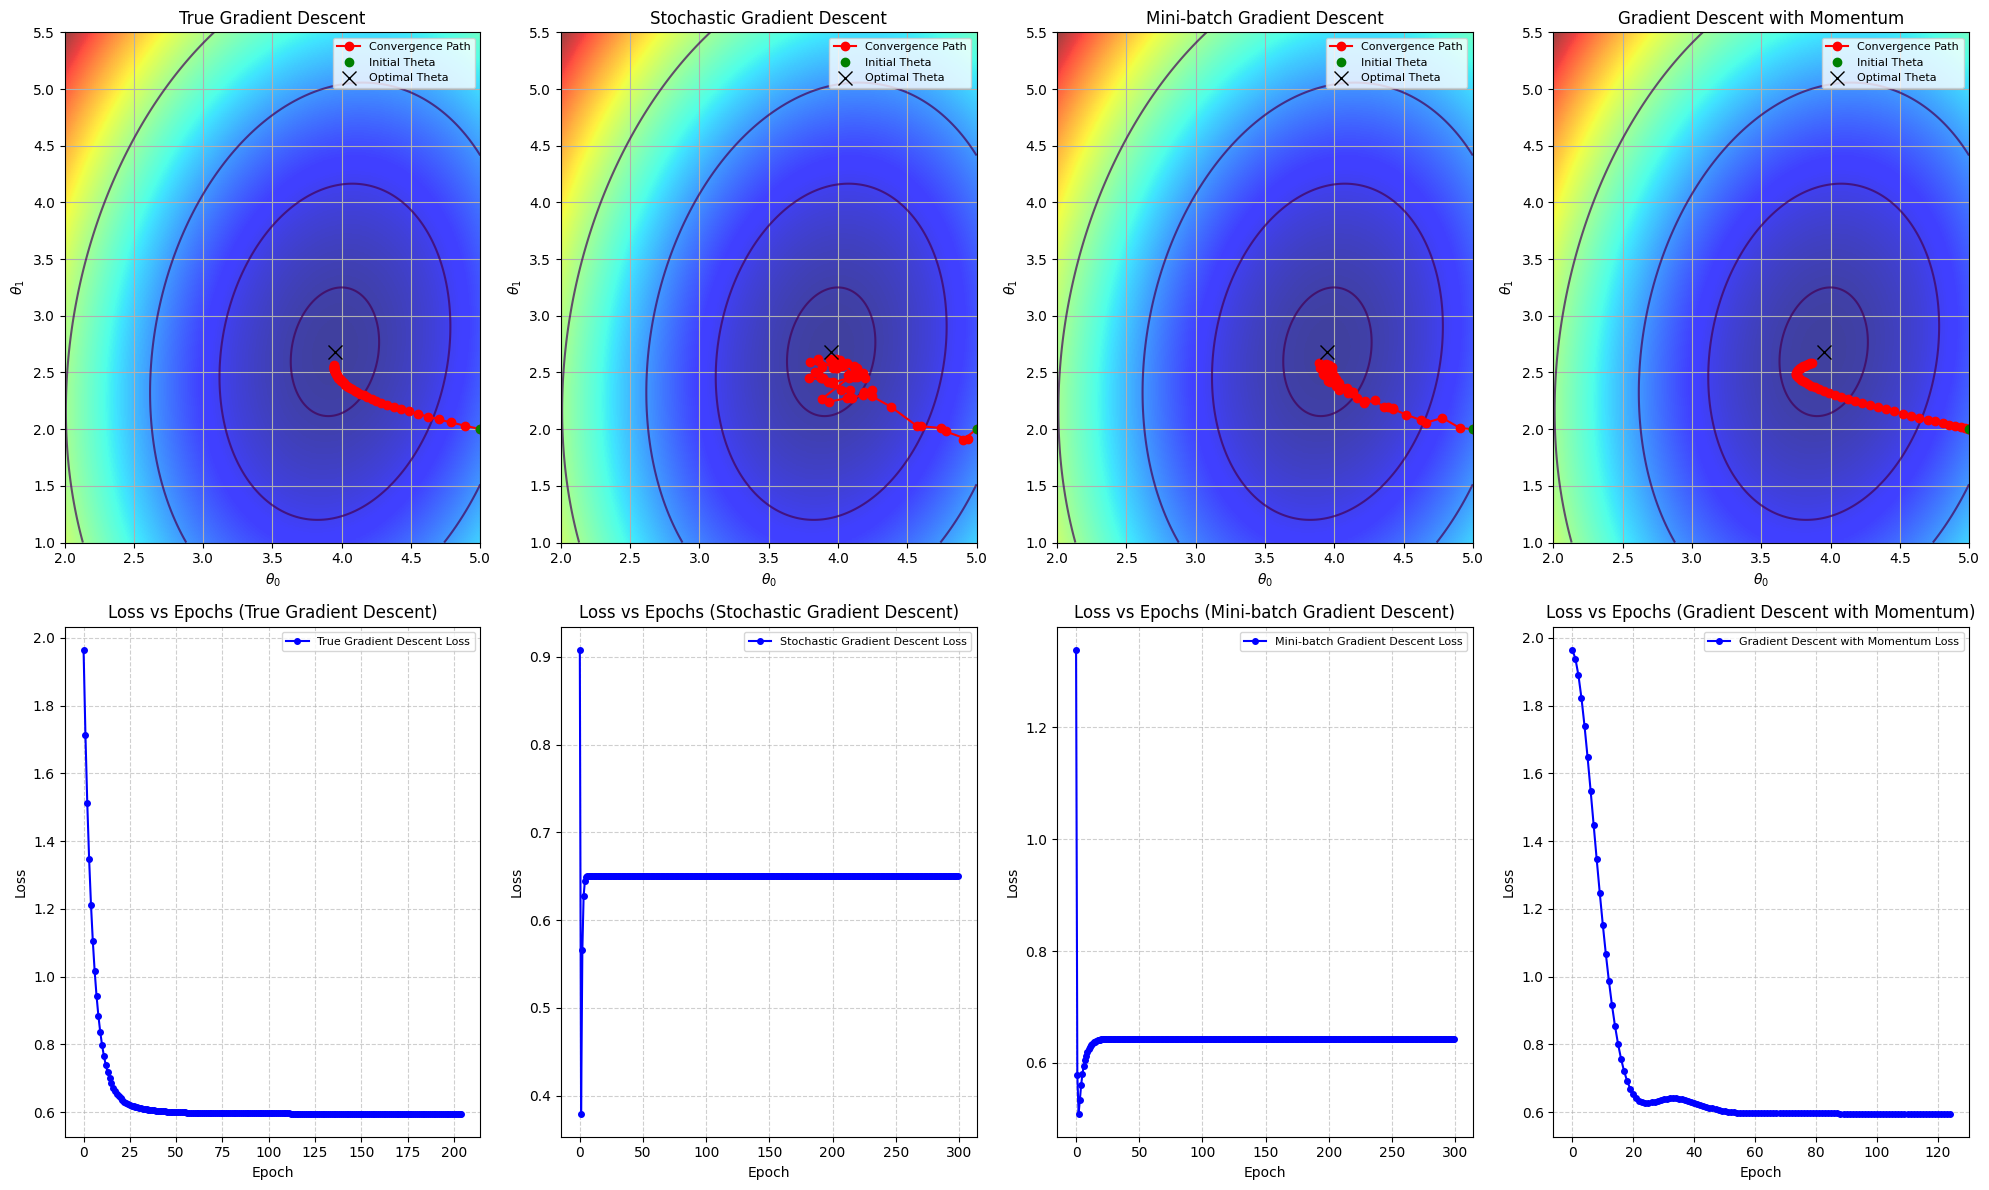

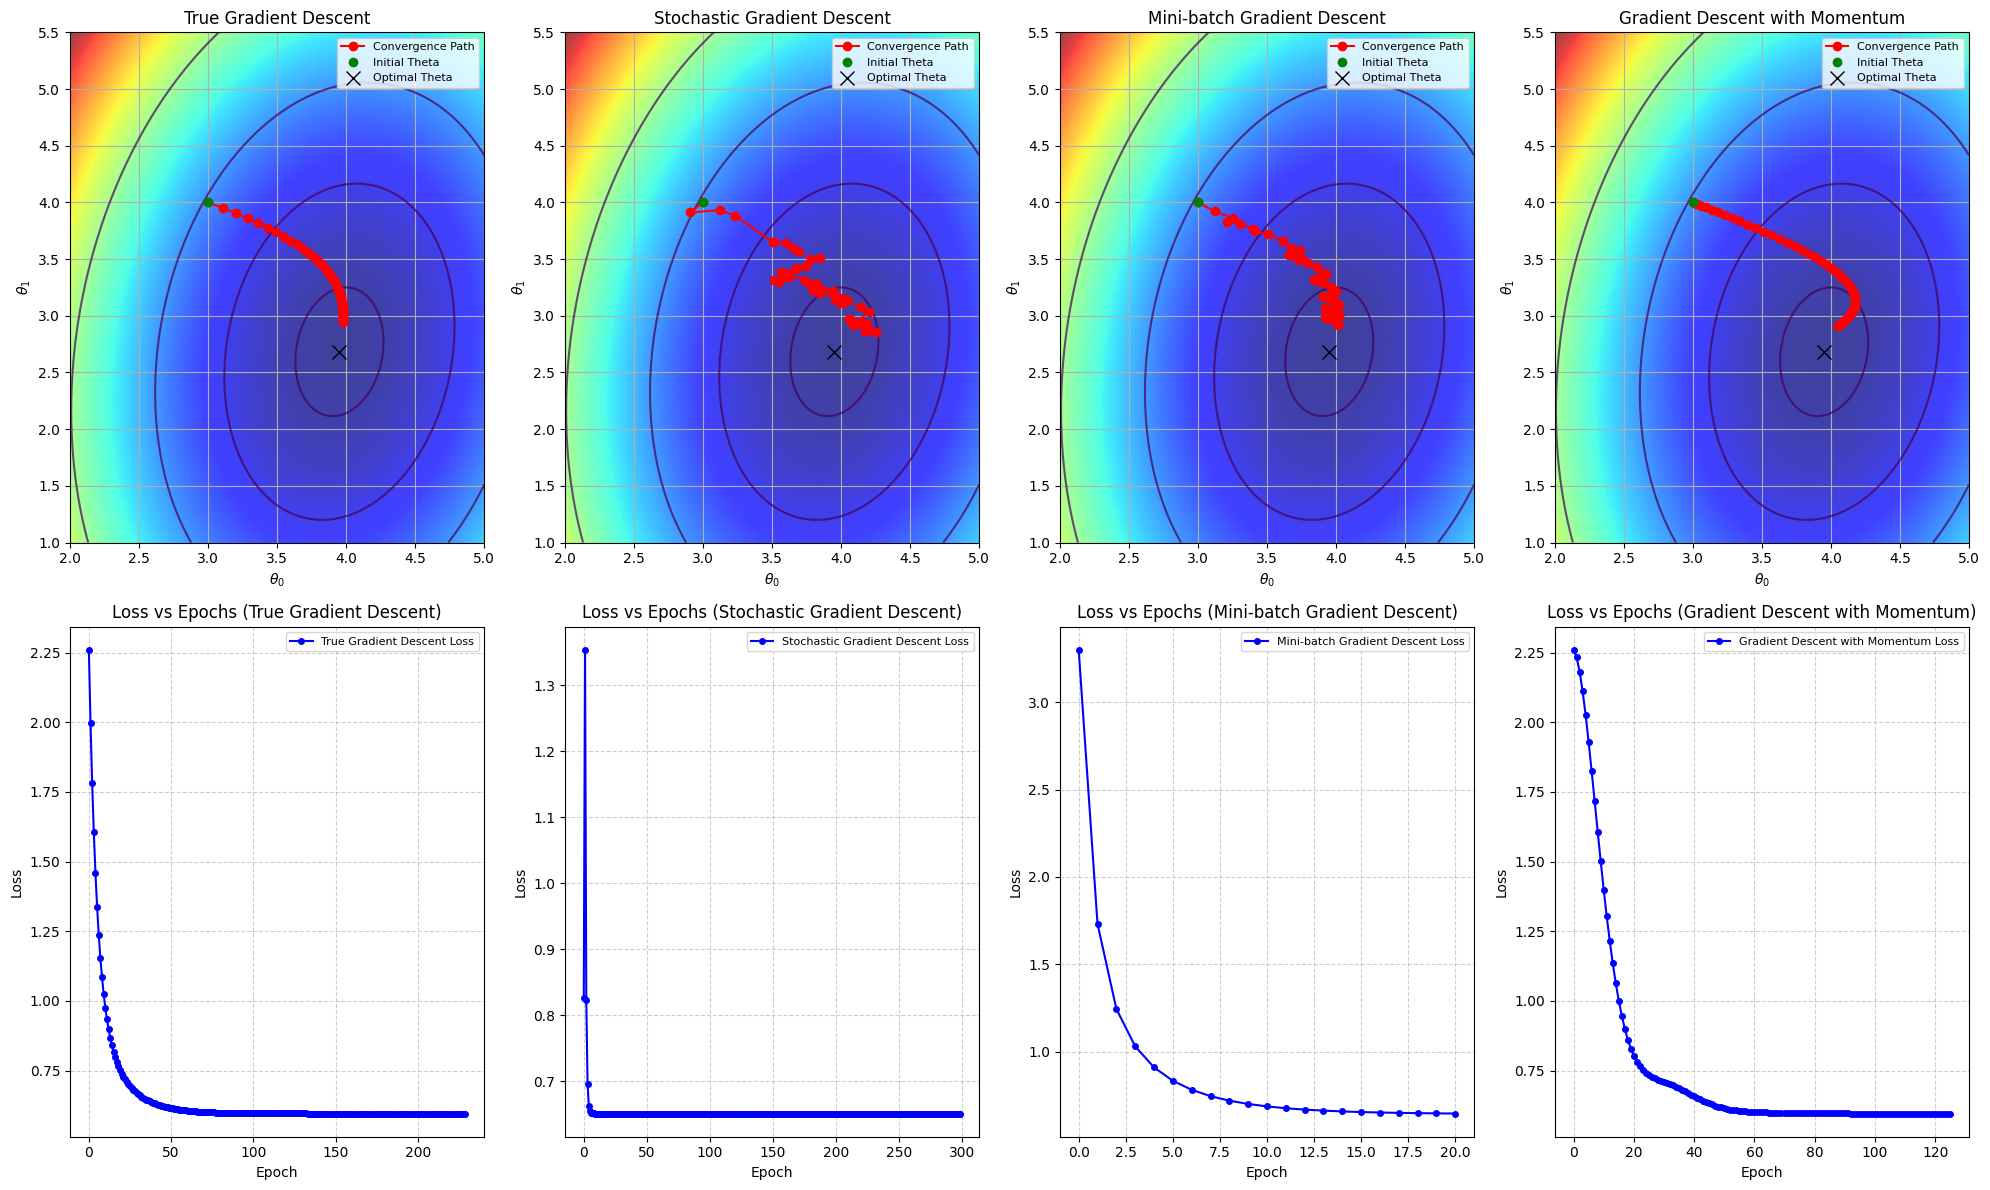

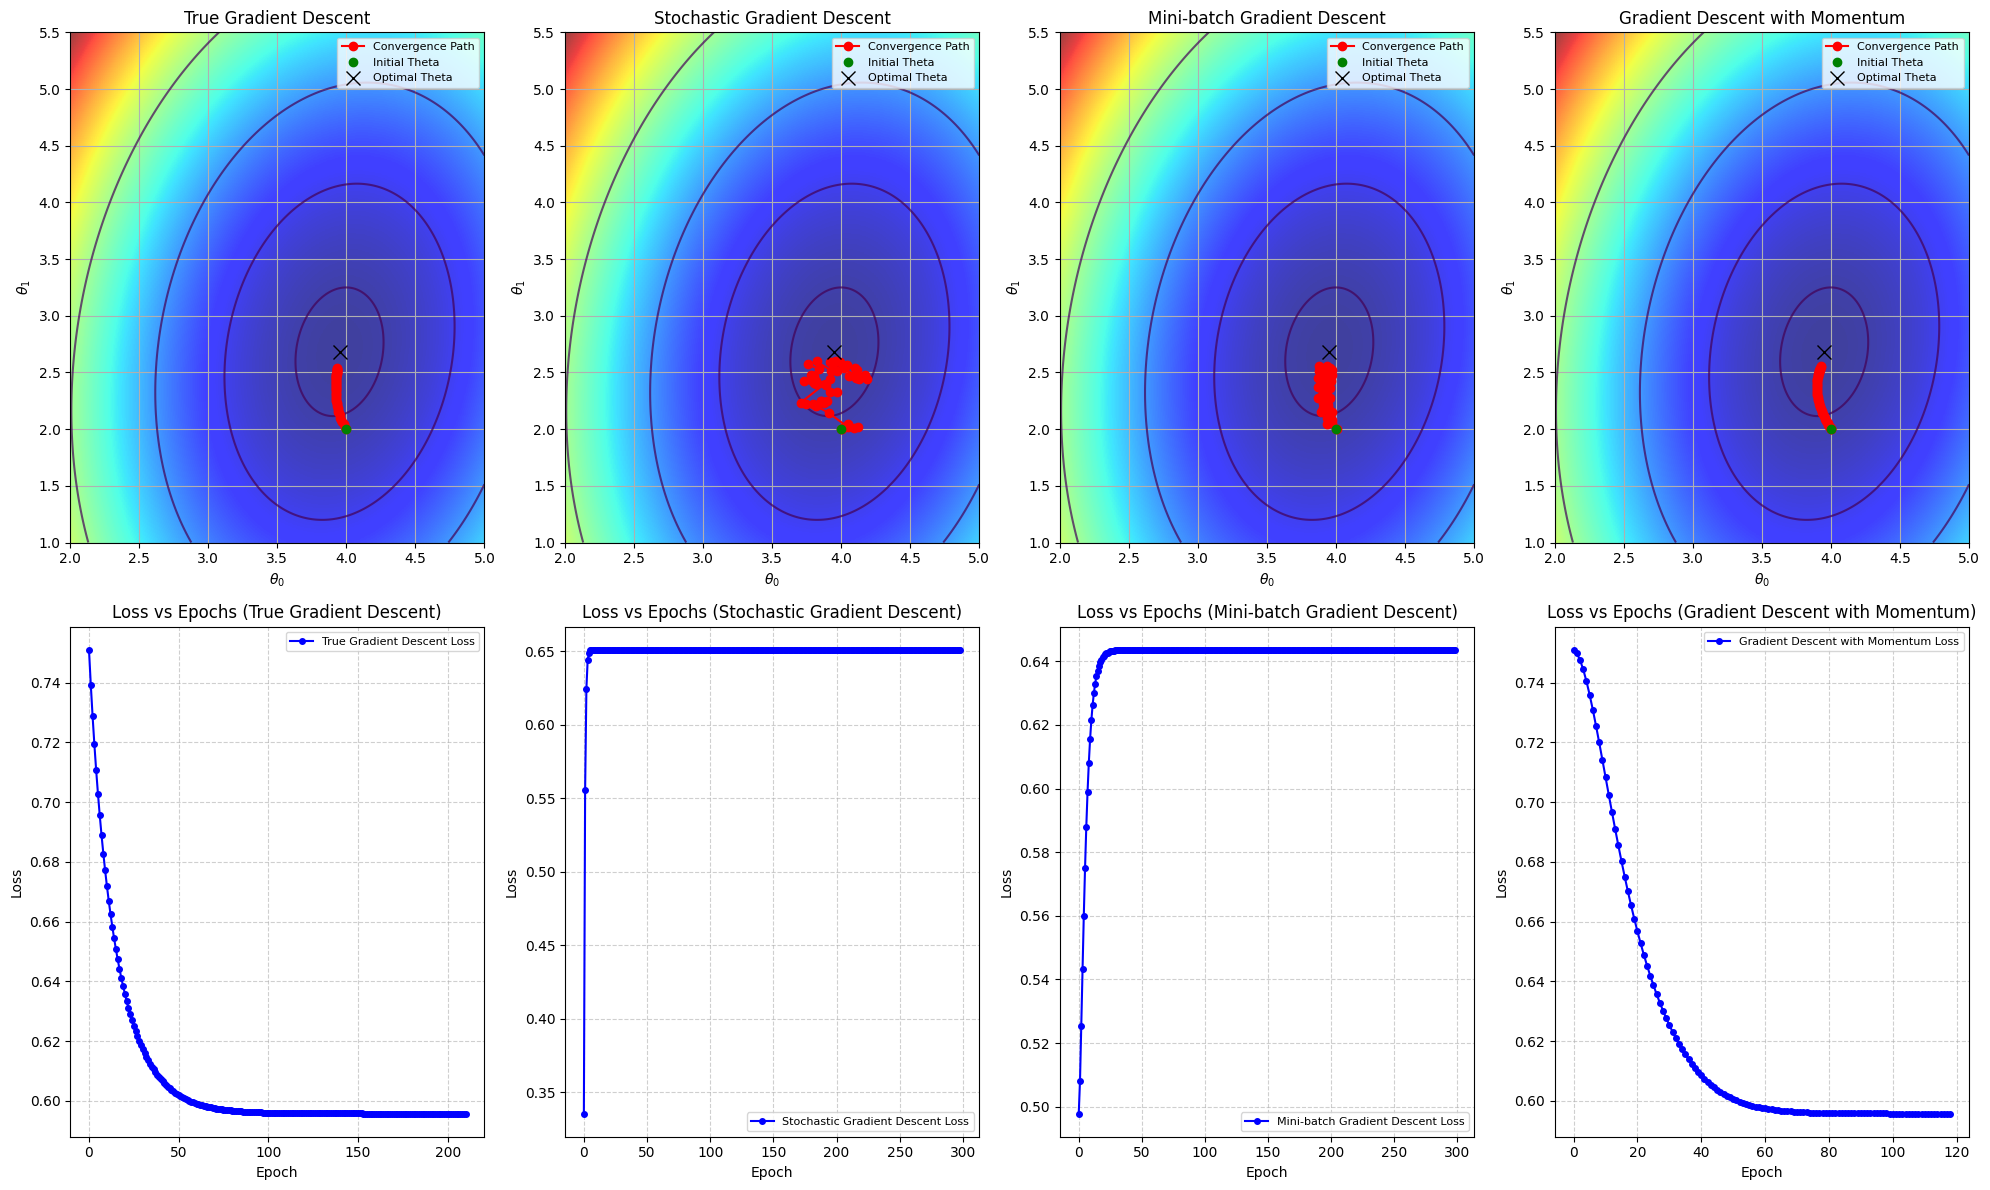

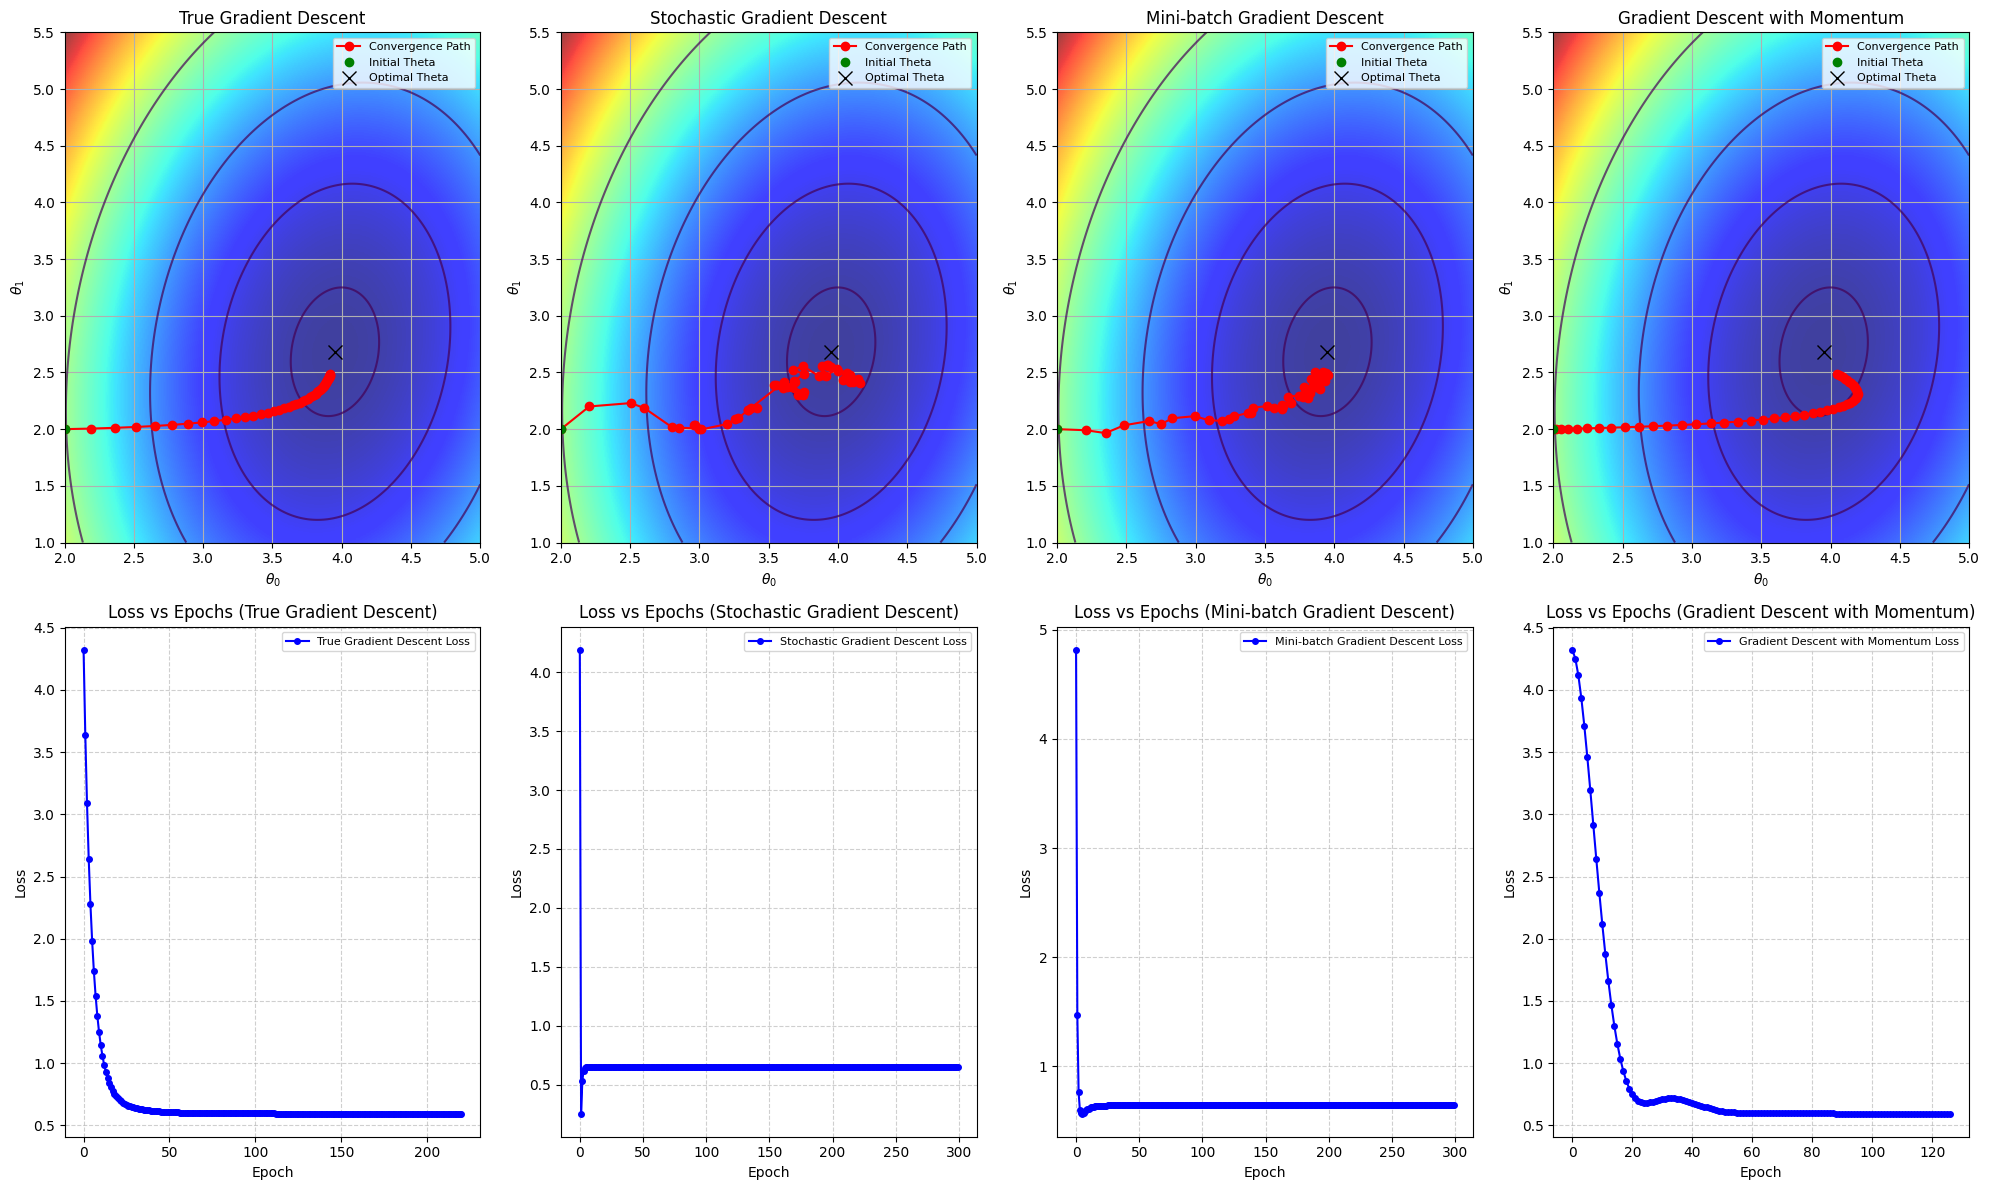

In [23]:
tgd_eps = []
sgd_eps = []
mbgd_eps = []
gdm_eps = []
sgd_iter = []
mbgd_iter = []


for i in range(10):
    theta = torch.randint(2,6,(2,),dtype = torch.float32,requires_grad = True)
    
    theta_evolution_tgd,eps_count_tgd,loss_tgd = true_gradient_descent(X,y,theta.clone().detach().requires_grad_(True),learning_rate,epsilon,max_epochs,optTheta)
    tgd_eps.append(eps_count_tgd)

    theta_evolution_sgd,eps_count_sgd,loss_sgd,iter_sgd = stochastic_gradient_descent(X,y,theta.clone().detach().requires_grad_(True),learning_rate,epsilon,max_epochs,num_samples,optTheta)
    sgd_eps.append(eps_count_sgd)
    sgd_iter.append(iter_sgd)

    theta_evolution_mbgd,batch_count_mgbd,eps_count_mbgd,loss_mbgd,iters_mbgd =mini_batch_gradient_descent(X,y,theta.clone().detach().requires_grad_(True),learning_rate,epsilon,max_epochs,num_samples,batch_size,optTheta)
    mbgd_eps.append(eps_count_mbgd)
    mbgd_iter.append(iters_mbgd)

    theta_evolution_gdm,eps_count_gdm,loss_gdm  =gradient_descent_with_momentum(X, y, theta.clone().detach().requires_grad_(True), learning_rate, epsilon, max_epochs, beta,optTheta)
    gdm_eps.append(eps_count_gdm)
    
    plot_all(X, y, theta_evolution_tgd, theta_evolution_sgd, theta_evolution_mbgd, theta_evolution_gdm,
         loss_tgd, loss_sgd, loss_mbgd, loss_gdm, optTheta)
    

In [24]:
print("Individual Epoch Counts:")

print(f"\nTrue Gradient Descent Epochs: {tgd_eps}")
print(f"Stochastic Gradient Descent Epochs: {sgd_eps}")
print(f"Mini-Batch Gradient Descent Epochs: {mbgd_eps}")
print(f"Gradient Descent with Momentum Epochs: {gdm_eps}")

print(f"\nStochastic Gradient Descent Iterations: {sgd_iter}")
print(f"Mini-Batch Gradient Descent Iterations: {mbgd_iter}")

sgd_total_iters = [40 * eps + iter_count for eps, iter_count in zip(sgd_eps, sgd_iter)]
mbgd_total_iters = [8 * eps + iter_count for eps, iter_count in zip(mbgd_eps, mbgd_iter)]

avg_tgd_eps = sum(tgd_eps) / len(tgd_eps)
avg_sgd_eps = sum(sgd_eps) / len(sgd_eps)
avg_mbgd_eps = sum(mbgd_eps) / len(mbgd_eps)
avg_gdm_eps = sum(gdm_eps) / len(gdm_eps)

avg_sgd_iter = sum(sgd_total_iters) / len(sgd_total_iters)
avg_mbgd_iter = sum(mbgd_total_iters) / len(mbgd_total_iters)

print("\nAverage Number of Epochs:")
print(f"True Gradient Descent: {avg_tgd_eps:.2f}")
print(f"Stochastic Gradient Descent: {avg_sgd_eps:.2f}")
print(f"Mini-Batch Gradient Descent: {avg_mbgd_eps:.2f}")
print(f"Gradient Descent with Momentum: {avg_gdm_eps:.2f}")

print("\nTotal Iterations:")
print(f"Stochastic Gradient Descent (with adjustment): {sgd_total_iters}")
print(f"Mini-Batch Gradient Descent (with adjustment): {mbgd_total_iters}")

print("\nAverage Total Number of Iterations:")
print(f"Stochastic Gradient Descent: {avg_sgd_iter:.2f}")
print(f"Mini-Batch Gradient Descent: {avg_mbgd_iter:.2f}")


Individual Epoch Counts:

True Gradient Descent Epochs: [233, 251, 142, 233, 230, 217, 205, 230, 211, 221]
Stochastic Gradient Descent Epochs: [300, 300, 300, 300, 300, 300, 300, 300, 300, 300]
Mini-Batch Gradient Descent Epochs: [22, 24, 11, 22, 22, 300, 300, 22, 300, 300]
Gradient Descent with Momentum Epochs: [123, 126, 127, 123, 126, 124, 125, 126, 119, 127]

Stochastic Gradient Descent Iterations: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Mini-Batch Gradient Descent Iterations: [3, 3, 3, 3, 3, 0, 0, 3, 0, 0]

Average Number of Epochs:
True Gradient Descent: 217.30
Stochastic Gradient Descent: 300.00
Mini-Batch Gradient Descent: 132.30
Gradient Descent with Momentum: 124.60

Total Iterations:
Stochastic Gradient Descent (with adjustment): [12000, 12000, 12000, 12000, 12000, 12000, 12000, 12000, 12000, 12000]
Mini-Batch Gradient Descent (with adjustment): [179, 195, 91, 179, 179, 2400, 2400, 179, 2400, 2400]

Average Total Number of Iterations:
Stochastic Gradient Descent: 12000.00
Mini-Batch 